# AR1 Validation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from statsmodels.nonparametric.smoothers_lowess import lowess

sns.set_theme(style="whitegrid", font_scale=1.2) 

df_og=pd.read_csv('../data/wide_weekly_scaledPer10k.csv')

## Load the AR1 model parameters

In [3]:
# Per region and time
df_mu       = pd.read_csv('../data/ar1/mu.csv')

# Per region
df_alpha    = pd.read_csv('../data/ar1/alpha.csv')
df_beta     = pd.read_csv('../data/ar1/beta.csv')
df_gamma    = pd.read_csv('../data/ar1/gamma.csv')
# Global
df_phi      = pd.read_csv('../data/ar1/phi.csv')
df_tau      = pd.read_csv('../data/ar1/tau.csv')

## Preprocess
Transform the og df into regions (cols) x time (weeks) 

In [4]:
df_mu.drop(columns=['time'], inplace=True)
df_og=df_og.T
df_og.columns=df_og.iloc[0]
df_og=df_og.drop(df_og.index[0])
df_og=df_og.reset_index(drop=True)

## Make the AR1 model estimate df
Formula
y[i,t] ~ dnorm(mu[i,t] + (phi * (y[i,t-1] - mu[i,t-1])), tau[i])

In [5]:
# Make the t-1 df
df_mu_t1 = df_mu.iloc[:df_mu.shape[0]-1]
df_og_t1 = df_og.iloc[:df_mu.shape[0]-1]
# Extract phi int
phi = df_phi['Mean'].tolist()[0]
# Extract first mu
df_mu_first = pd.DataFrame([df_mu.iloc[0]])
# Extract not first mu
df_mu_rest = df_mu.iloc[1:].reset_index(drop=True)
# Calculate AR(1)
df_ar1 = df_mu_rest + (phi * (df_og_t1 - df_mu_t1))
df_ar1 = pd.concat([df_mu_first, df_ar1], ignore_index=True)
df_ar1
# Calculate AR(1) w/o Seasonality
df_ar1 = df_mu_rest + (phi * (df_og_t1 - df_mu_t1))
df_ar1 = pd.concat([df_mu_first, df_ar1], ignore_index=True)
df_ar1

,HSE Dublin and Midlands,HSE Dublin and North East,HSE Dublin and South East,HSE Mid West,HSE South West,HSE West and North West
0,4.244922,2.696819,3.34936,7.504588,4.970216,6.113386
1,2.44735,1.589863,1.852491,4.013526,2.797408,3.436317
2,5.819502,3.99002,4.857175,7.284282,6.205959,8.648576
3,5.092879,3.052509,4.014351,5.55511,4.986099,6.123317
4,4.981536,2.565283,3.492063,6.055665,4.997132,7.2259
...,...,...,...,...,...,...
146,2.885993,1.901719,2.864246,7.092936,4.876297,6.441272
147,2.51397,1.709849,2.994299,5.701828,5.171607,5.264688
148,2.54505,1.758349,2.96714,5.266736,4.449536,5.715793
149,2.900489,1.886004,2.915366,5.570212,4.907708,5.2967


## Plot MU
This should look like yearly oscillations

In [6]:
# Get CI bounds for mu
df_mu_lower = pd.read_csv('../data/ar1/mu025.csv')
df_mu_upper = pd.read_csv('../data/ar1/mu975.csv')
df_mu_lower.drop(columns=['time'], inplace=True)
df_mu_upper.drop(columns=['time'], inplace=True)  

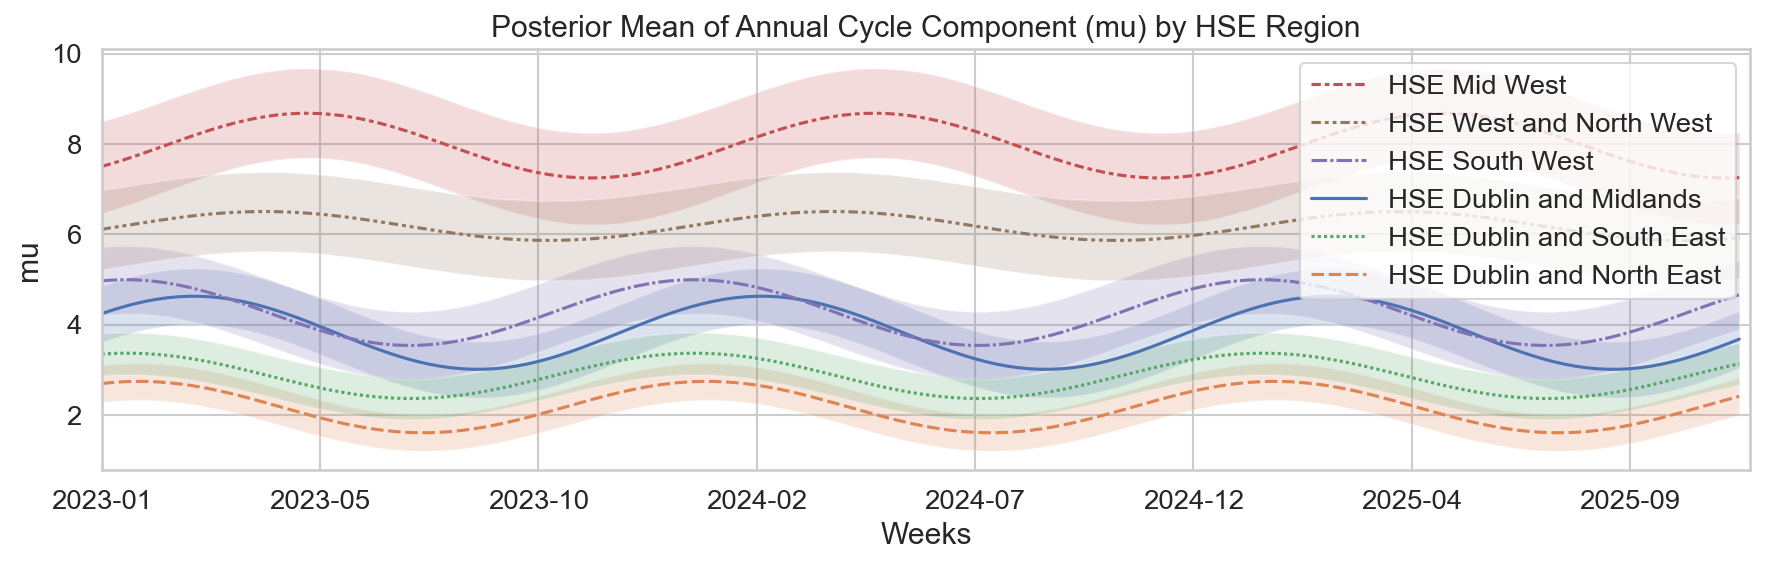

In [7]:
plt.figure(figsize=(12, 4), dpi=150)

# convert mu index to datetime
# df_mu.index=pd.to_datetime('2023-01-01') + pd.to_timedelta(df_mu.index, unit='W')

# plot data
axs = sns.lineplot(data=df_mu)
# plot ci
for col in df_mu.columns:
    # plt.plot(df_mu.index, df_mu[col], label=col)
    plt.fill_between(df_mu.index, df_mu_lower[col], df_mu_upper[col], alpha=0.2)
# annotations--------
# vertical lines

axs.set_title('Posterior Mean of Annual Cycle Component (mu) by HSE Region')
axs.set_xlabel('Weeks')
axs.set_ylabel('mu')
axs.set_xlim(0, df_mu.shape[0])

# Set x-ticks and labels
axs.set_xticks(df_mu.index[::20])
x_labels = pd.to_datetime('2023-01-01') + pd.to_timedelta(df_mu.index, unit='W')
x_labels = x_labels.strftime('%Y-%m')
axs.set_xticklabels(x_labels[::20])

plt.legend(loc='upper right')

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [3,5,4,0,2,1]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 


plt.tight_layout()

CI's Look Uniform/Unchanging...

Display 2.5% - 97.5% Credible Intervals To Validate that they are different, time point to time point

In [8]:
# Show the residuals for HSE Mid West
pd.concat([df_mu_lower.rename(columns={'HSE Dublin and Midlands': 'HSE Dublin and Midlands: Lower CI'})['HSE Dublin and Midlands: Lower CI'],\
           df_mu_upper.rename(columns={'HSE Dublin and Midlands': 'HSE Dublin and Midlands: Upper CI'})['HSE Dublin and Midlands: Upper CI'],\
           df_mu_lower.rename(columns={'HSE Dublin and North East': 'HSE Dublin and North East: Lower CI'})['HSE Dublin and North East: Lower CI'],\
           df_mu_upper.rename(columns={'HSE Dublin and North East': 'HSE Dublin and North East: Upper CI'})['HSE Dublin and North East: Upper CI'],\
           df_mu_lower.rename(columns={'HSE Mid West': 'HSE Mid West: Lower CI'})['HSE Mid West: Lower CI'],\
           df_mu_upper.rename(columns={'HSE Mid West': 'HSE Mid West: Upper CI'})['HSE Mid West: Upper CI']],\
            axis=1)

,HSE Dublin and Midlands: Lower CI,HSE Dublin and Midlands: Upper CI,HSE Dublin and North East: Lower CI,HSE Dublin and North East: Upper CI,HSE Mid West: Lower CI,HSE Mid West: Upper CI
0,3.615223,4.861957,2.284387,3.099412,6.476751,8.500807
1,3.696218,4.940402,2.308192,3.122392,6.544476,8.570468
2,3.770476,5.013801,2.325108,3.138027,6.625352,8.647025
3,3.835561,5.077768,2.333264,3.144901,6.706319,8.722093
4,3.893145,5.133124,2.334362,3.145075,6.796432,8.807950
...,...,...,...,...,...,...
146,2.695458,3.946989,1.737988,2.549611,6.269204,8.287870
147,2.772026,4.028941,1.804512,2.619216,6.240173,8.262475
148,2.858023,4.115512,1.872488,2.687477,6.225856,8.250286
149,2.950194,4.207013,1.938628,2.753723,6.222878,8.248929


## Alpha (baseline)

In [9]:
df_alpha.sort_values('Mean', ascending=False).round(2).to_excel('~/Downloads/alpha_values.xlsx')

## Plot Full AR1 Model

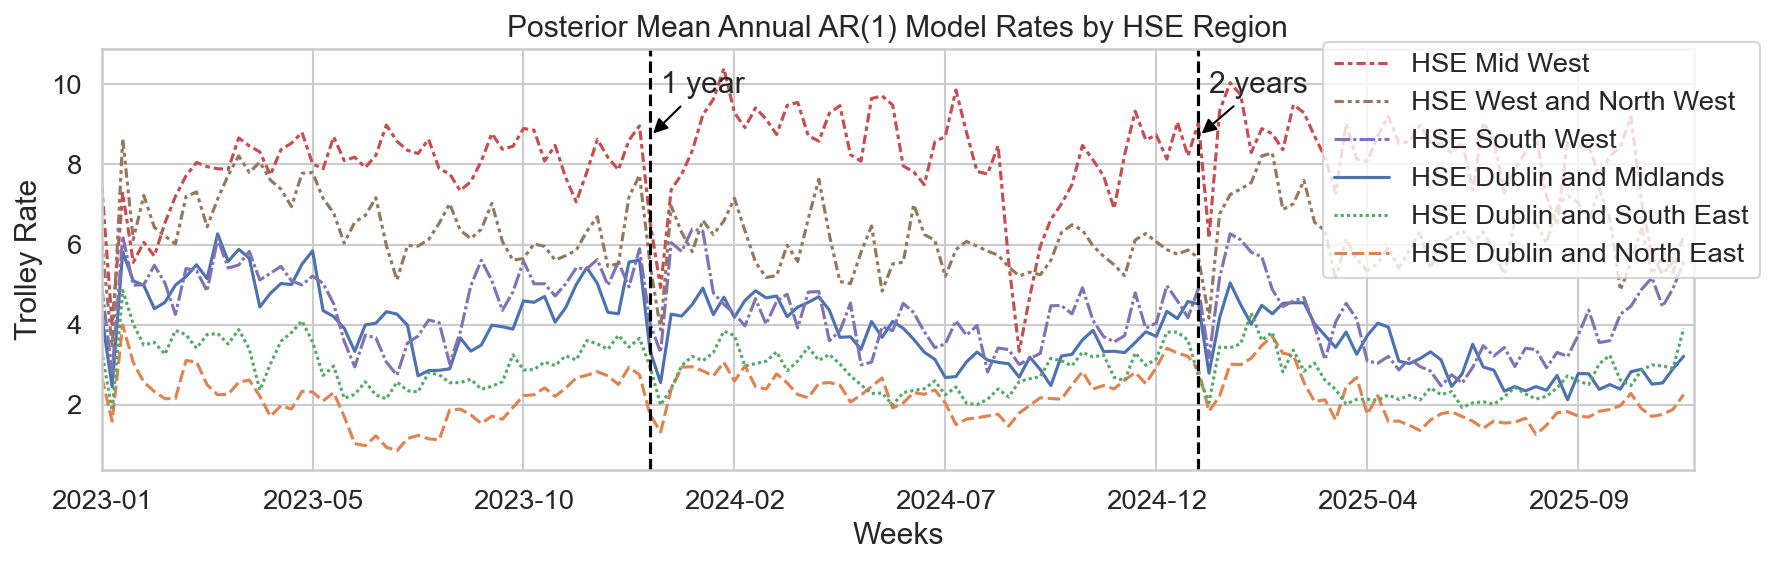

In [11]:
plt.figure(figsize=(12, 4), dpi=150)

axs = sns.lineplot(data=df_ar1)

axs.axvline(x=104, color='black', linestyle='--')
axs.axvline(x=52, color='black', linestyle='--')

axs.annotate('2 years', xy=(104, plt.ylim()[1]*0.8), xytext=(105, plt.ylim()[1]*.90), arrowprops=dict(arrowstyle='-|>', color='black'))
axs.annotate('1 year',  xy=(52,  plt.ylim()[1]*0.8), xytext=(53, plt.ylim()[1]*.90),  arrowprops=dict(arrowstyle='-|>', color='black'))

axs.set_xlim(0, df_ar1.shape[0])

axs.set_title('Posterior Mean Annual AR(1) Model Rates by HSE Region')
axs.set_xlabel('Weeks')
axs.set_ylabel('Trolley Rate')

# Set x-ticks and labels
axs.set_xticks(df_ar1.index[::20])
x_labels = pd.to_datetime('2023-01-01') + pd.to_timedelta(df_ar1.index, unit='W')
x_labels = x_labels.strftime('%Y-%m')
axs.set_xticklabels(x_labels[::20])

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [3,5,4,0,2,1]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],\
            loc='upper right', bbox_to_anchor=(1.05, 1.05))

# plt.legend(loc='upper right')
plt.tight_layout()

## Plot AR1 Without Seasonal Component 

In [269]:
x_labels

Index(['2023-01', '2023-01', '2023-01', '2023-01', '2023-01', '2023-02',
       '2023-02', '2023-02', '2023-02', '2023-03',
       ...
       '2025-09', '2025-09', '2025-09', '2025-10', '2025-10', '2025-10',
       '2025-10', '2025-11', '2025-11', '2025-11'],
      dtype='object', length=151)

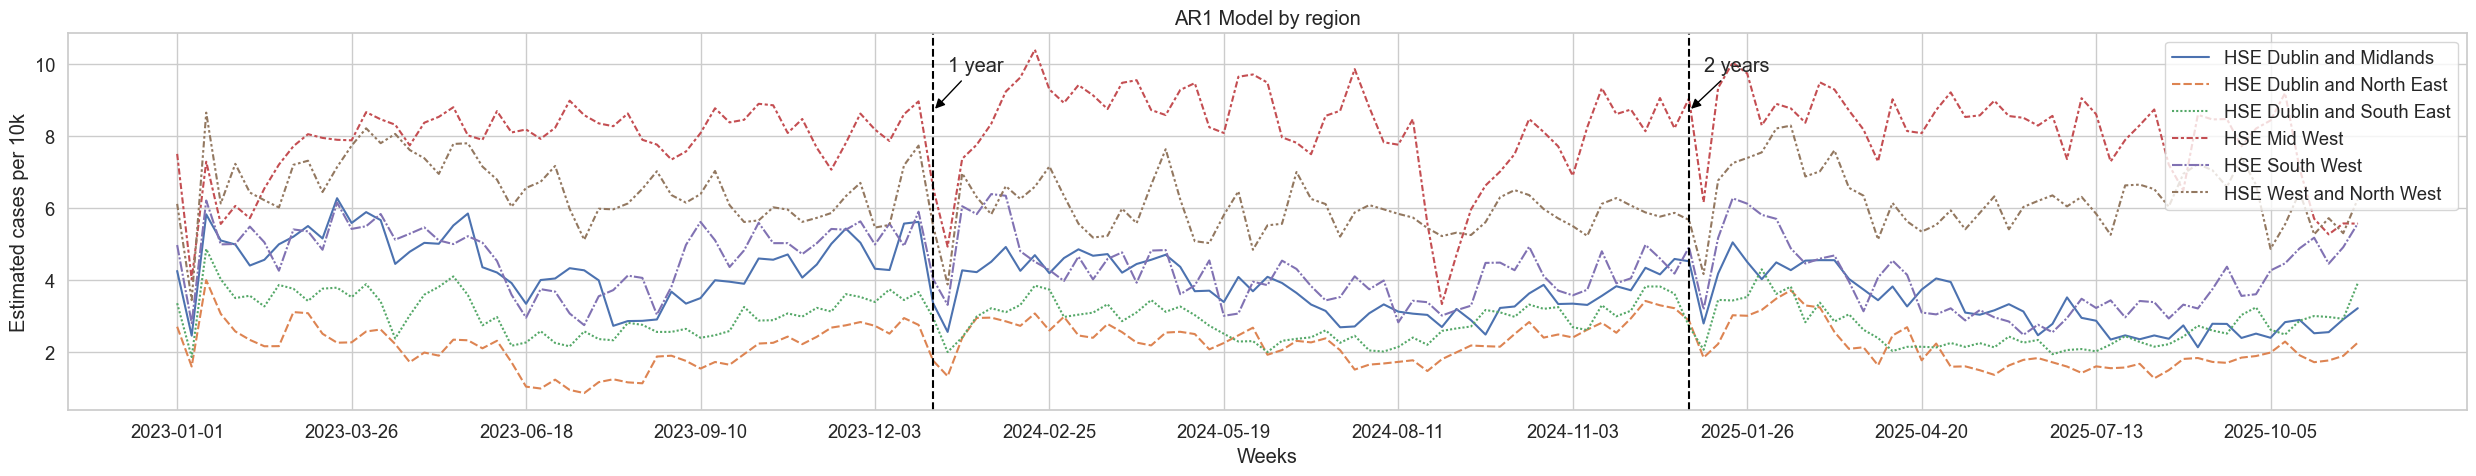

In [270]:
plt.figure(figsize=(25,5))

# df_ar1.index=pd.to_datetime('2023-01-01') + pd.to_timedelta(df_ar1.index, unit='W')

axs = sns.lineplot(data=df_ar1)

axs.axvline(x=104, color='black', linestyle='--')
axs.axvline(x=52, color='black', linestyle='--')

axs.annotate('2 years', xy=(104, plt.ylim()[1]*0.8), xytext=(105, plt.ylim()[1]*.90), arrowprops=dict(arrowstyle='-|>', color='black'))
axs.annotate('1 year',  xy=(52,  plt.ylim()[1]*0.8), xytext=(53, plt.ylim()[1]*.90),  arrowprops=dict(arrowstyle='-|>', color='black'))


axs.set_title('AR1 Model by region')
axs.set_xlabel('Weeks')
axs.set_ylabel('Estimated cases per 10k')

# Set x-ticks and labels
axs.set_xticks(df_ar1.index[::12])
x_labels = pd.to_datetime('2023-01-01') + pd.to_timedelta(df_ar1.index, unit='W')
x_labels = x_labels.strftime('%Y-%m-%d')
axs.set_xticklabels(x_labels[::12])

plt.legend(loc='upper right')
plt.tight_layout()

/var/folders/8p/bnwtr4b93fn3_th1x9ysmwy00000gn/T/ipykernel_43013/1926983928.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(pd.to_datetime('2023-01-01') + pd.to_timedelta(df_ar1.index, unit='W'))


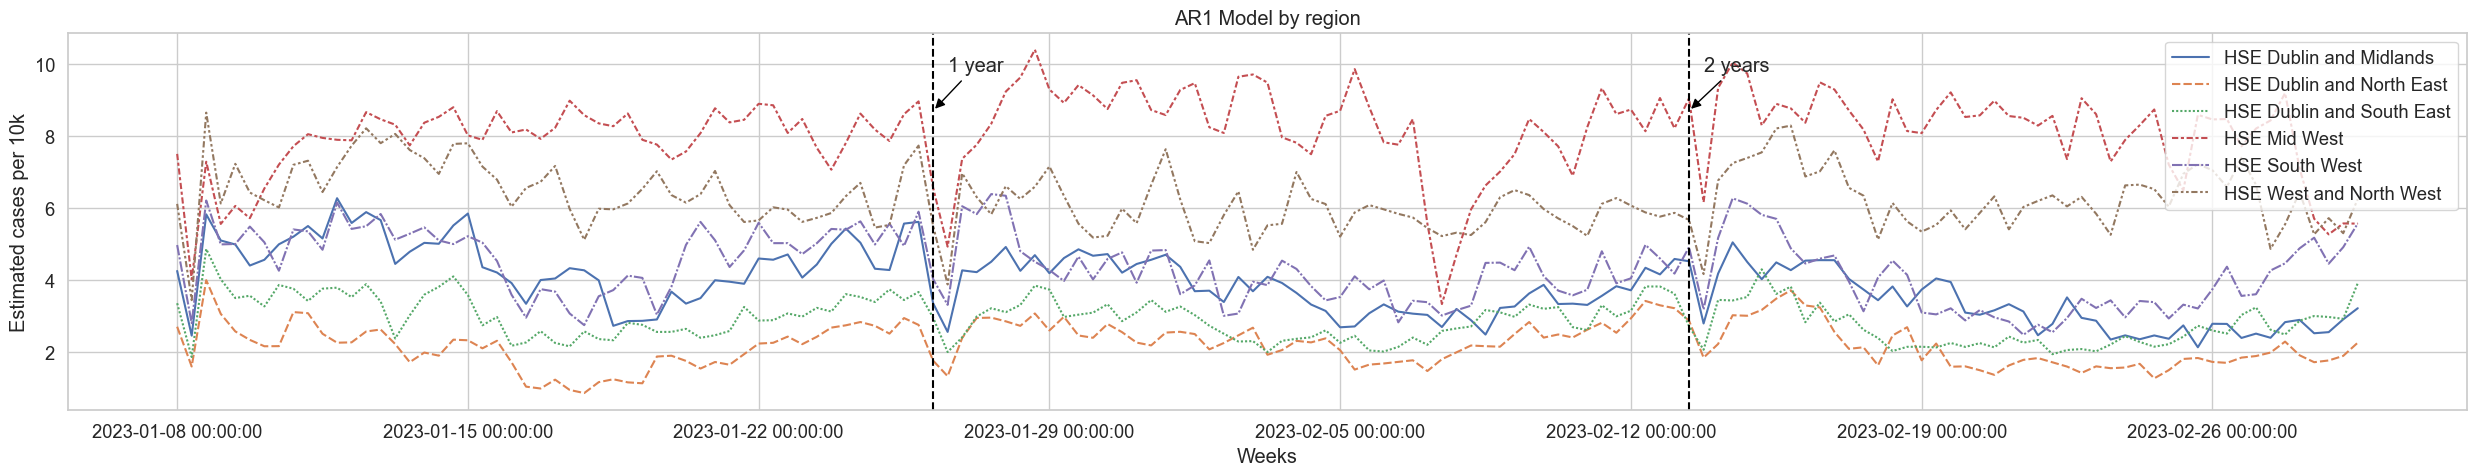

In [271]:
plt.figure(figsize=(25,5))

axs = sns.lineplot(data=df_ar1)

axs.axvline(x=104, color='black', linestyle='--')
axs.axvline(x=52, color='black', linestyle='--')

axs.annotate('2 years', xy=(104, plt.ylim()[1]*0.8), xytext=(105, plt.ylim()[1]*.90), arrowprops=dict(arrowstyle='-|>', color='black'))
axs.annotate('1 year',  xy=(52,  plt.ylim()[1]*0.8), xytext=(53, plt.ylim()[1]*.90),  arrowprops=dict(arrowstyle='-|>', color='black'))


axs.set_title('AR1 Model by region')
axs.set_xlabel('Weeks')
axs.set_ylabel('Estimated cases per 10k')

axs.set_xticklabels(pd.to_datetime('2023-01-01') + pd.to_timedelta(df_ar1.index, unit='W'))

plt.legend(loc='upper right')
plt.tight_layout()

## Plot the residuals

**Calculate data frame of residuals**

In [272]:
df_residuals = df_og - df_ar1

**Plot**

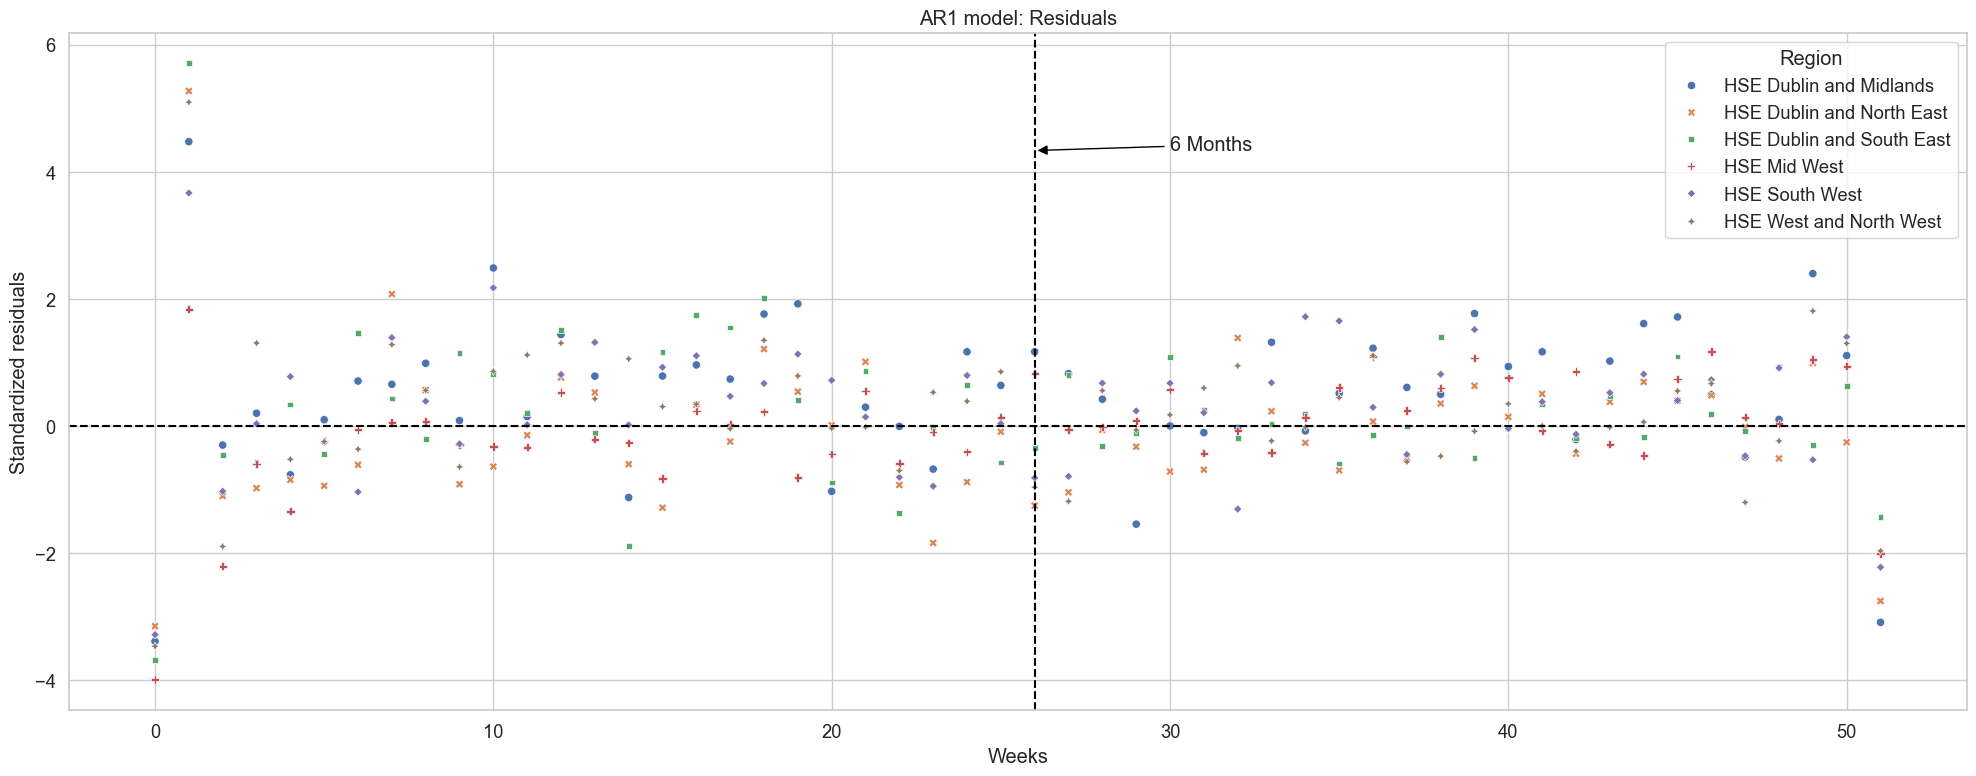

In [273]:
plt.figure(figsize=(20,8))

# annotation text
y_loc=.7; x_shift=4

# standardized residuals
df_std_resid = df_residuals/df_residuals.std()

axs = sns.scatterplot(data=df_std_resid.iloc[:52, :])
# for col in df_std_resid.columns:
#     smooth = lowess(df_std_resid[col], df_ar1[col], frac=2/3, return_sorted=True)
#     sns.lineplot(x=range(len(smooth[:,1])),y=smooth[:,1], color='red')
    
# annotations
# axs.axvline(x=104, color='black', linestyle='--', label='104 Weeks')
# axs.axvline(x=52,  color='black', linestyle='--', label='52 Weeks')
axs.axvline(x=26,  color='black', linestyle='--', label='6 Months')
axs.axhline(y=0,  color='black', linestyle='--', label='52 Weeks')


# axs.annotate('2 years', xy=(104, plt.ylim()[1]*y_loc), xytext=(104+x_shift, plt.ylim()[1]*y_loc), arrowprops=dict(arrowstyle='-|>', color='black'))
# axs.annotate('1 year',  xy=(52,  plt.ylim()[1]*y_loc), xytext=(52 +x_shift, plt.ylim()[1]*y_loc), arrowprops=dict(arrowstyle='-|>', color='black'))
axs.annotate('6 Months',  xy=(26,  plt.ylim()[1]*y_loc), xytext=(26 +x_shift, plt.ylim()[1]*y_loc), arrowprops=dict(arrowstyle='-|>', color='black'))

axs.set_title('AR1 model: Residuals')
axs.set_xlabel('Weeks')
axs.set_ylabel('Standardized residuals')

plt.tight_layout()

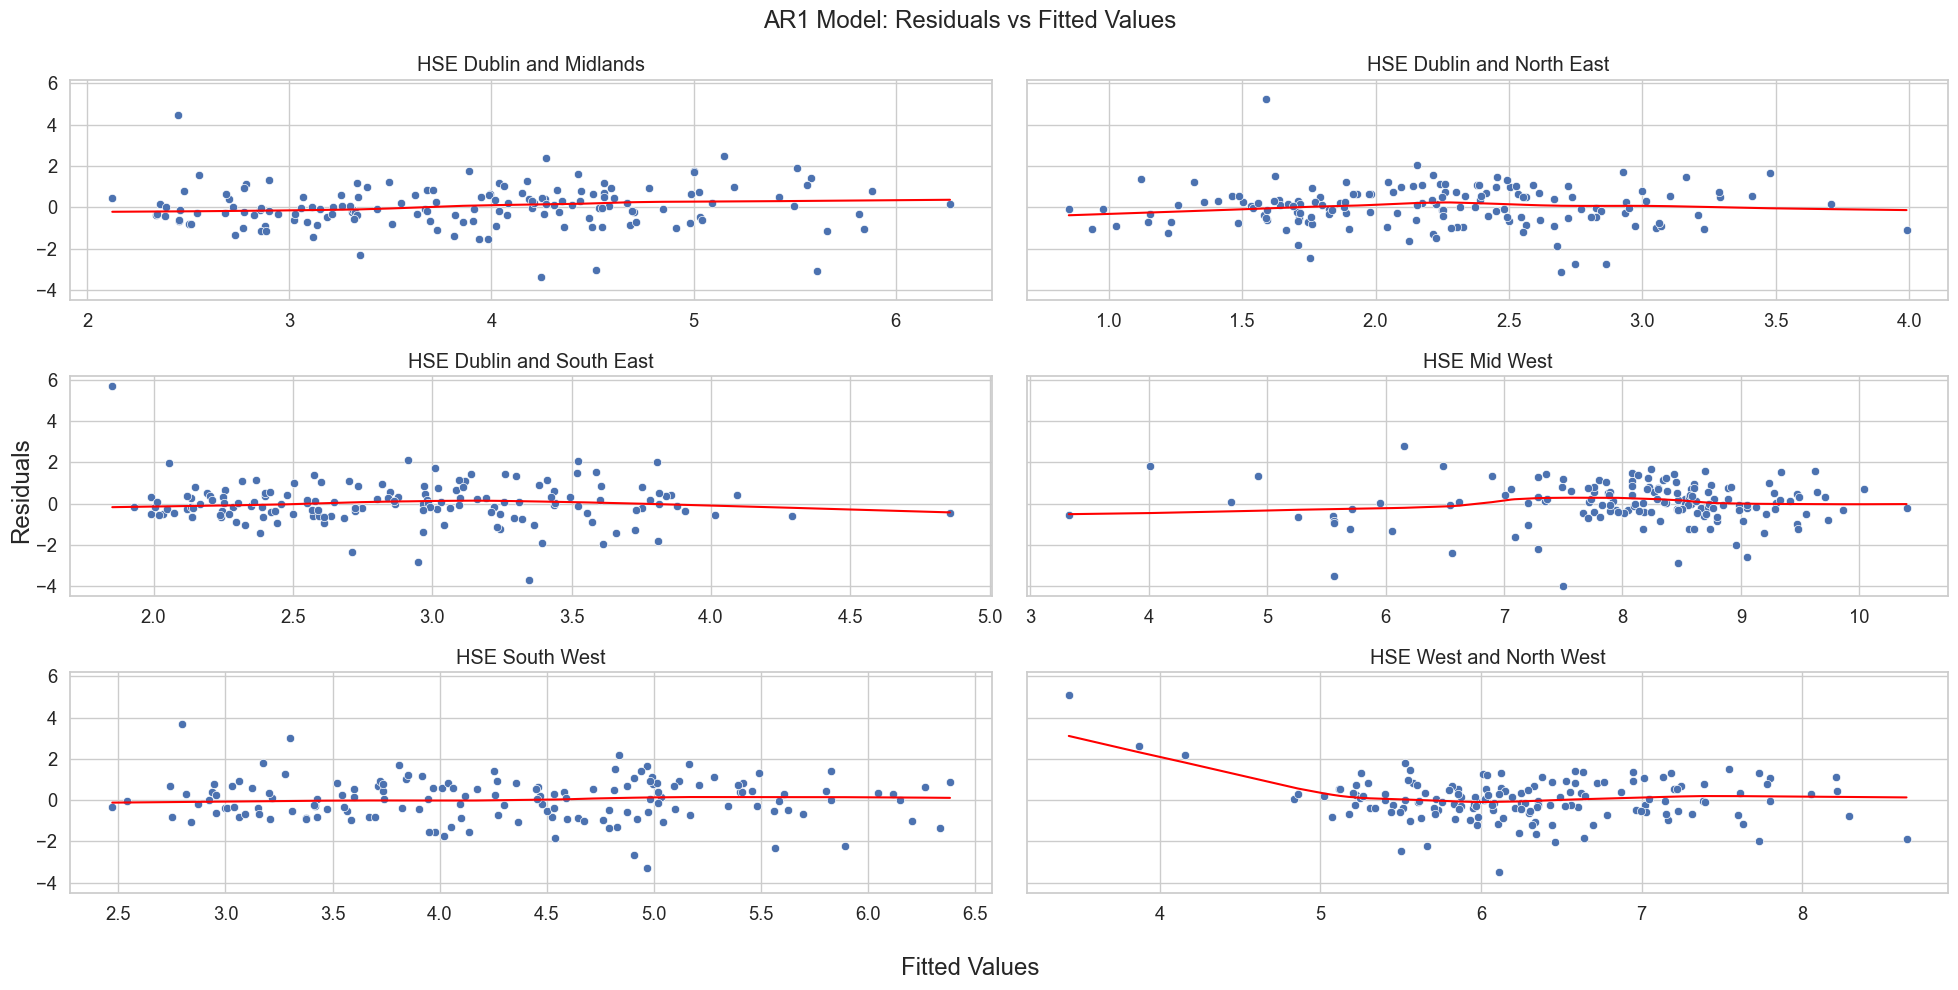

In [274]:
# annotation text
y_loc=.7; x_shift=10
fig, axes = plt.subplots(3, 2, figsize=(20, 10), sharey=True)

# standardized residuals
df_std_resid = df_residuals/df_residuals.std()

for col, ax in zip(df_std_resid.columns, axes.flatten()):

    sns.scatterplot(x=df_ar1[col], y=df_std_resid[col], ax=ax)
    # for col in df_std_resid.columns:
    smooth = lowess(df_std_resid[col], df_ar1[col], frac=2/3, return_sorted=True)
    sns.lineplot(x=smooth[:,0], y=smooth[:,1], ax=ax, color='red')

    ax.annotate('2 years', xy=(104, plt.ylim()[1]*y_loc), xytext=(104+x_shift, plt.ylim()[1]*y_loc), arrowprops=dict(arrowstyle='-|>', color='black'))
    ax.annotate('1 year',  xy=(52,  plt.ylim()[1]*y_loc), xytext=(52 +x_shift, plt.ylim()[1]*y_loc), arrowprops=dict(arrowstyle='-|>', color='black'))

    ax.set_title(col)
    ax.set_ylabel('')
    ax.set_xlabel('')

fig.suptitle('AR1 Model: Residuals vs Fitted Values')
fig.supxlabel('Fitted Values')
fig.supylabel('Residuals')

plt.tight_layout()

**Notes**
* Yearly shock not captured by the AR1 oscillatory components. Likely too high a frequency for a 52 width sinusoid(?).
* Overall Looks like the residuals have a normal variance. Stays tight to the 0 point.  

**QQ-Plot For Residuals**

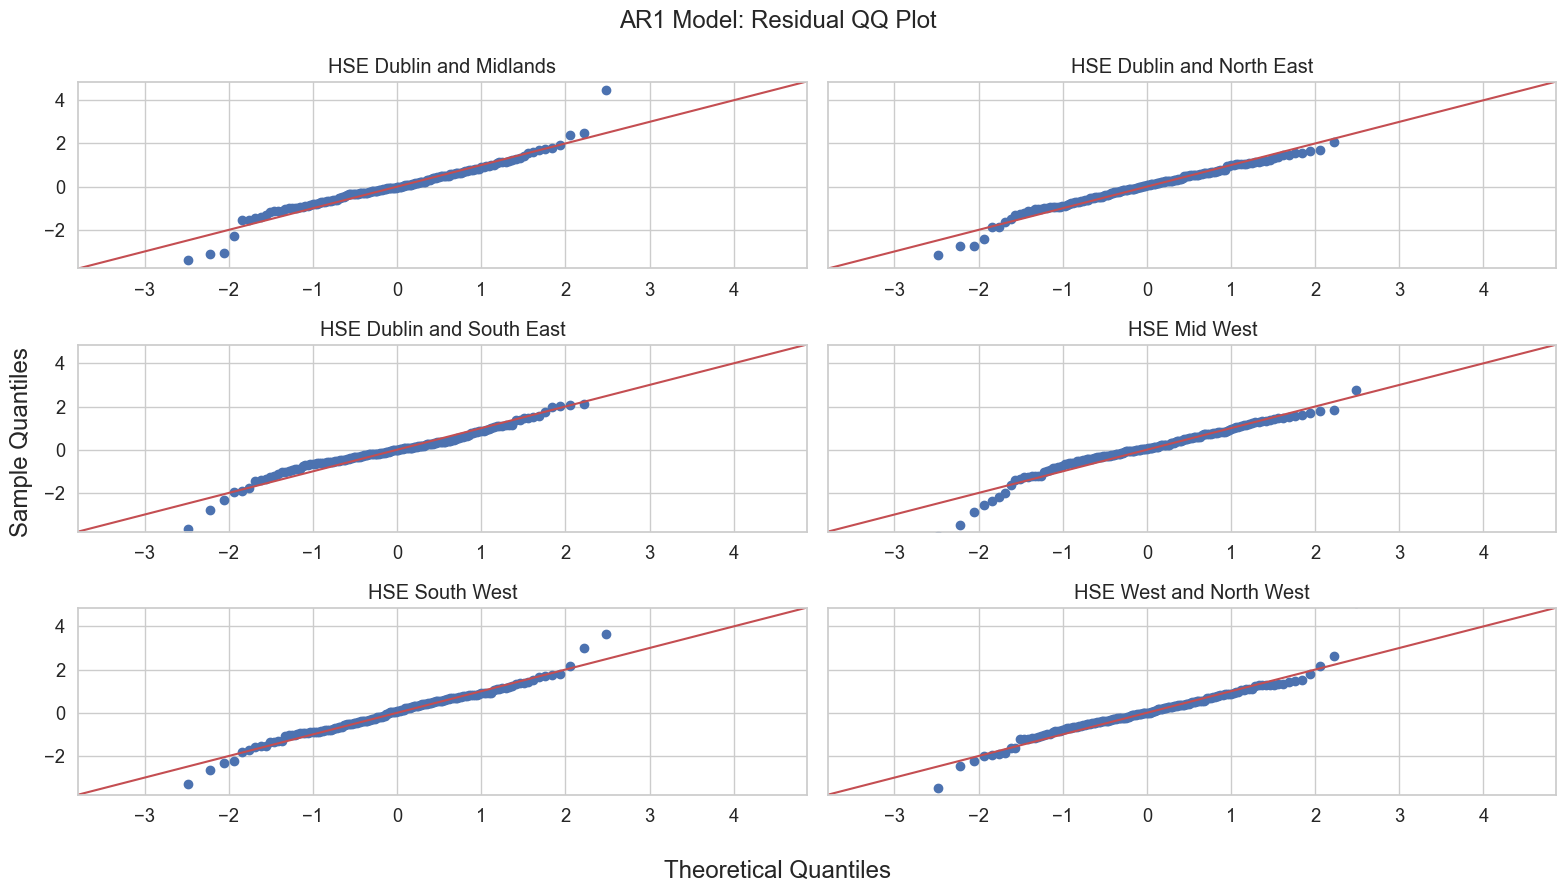

In [275]:
# Q-Q plot
fig, axes = plt.subplots(3, 2, figsize=(16, 9), sharey=True)
for i, (ax, col) in enumerate(zip(axes.flatten(), df_std_resid.columns)):
    qqplot(df_std_resid[col], line='45', ax=ax)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(col)

fig.suptitle('AR1 Model: Residual QQ Plot')
fig.supxlabel('Theoretical Quantiles')
fig.supylabel('Sample Quantiles')
plt.tight_layout()
